# Table of Contents
1. [Business Understanding](#Business-Understanding)

1. [Exploratory Data Analysis and Visualisation](#Exploratory-Data-Analysis)

1. [Churn Modeling](#Churn-Modeling)

    1. [Feature preprocessing](#Feature-preprocessing)
    1. [Churn prediction](#Churn-prediction)
    
1. [Marketing campaign: 20% discount churned custormers](#Marketing-campaign:-20%-discount-churned-customers)


In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from fancyimpute import KNN

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, roc_auc_score, auc, brier_score_loss

from functools import reduce
import graphviz

random_state = np.random.RandomState(1)
np.random.seed(1) # for reproducibility

In [3]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15, 5)

pd.set_option('display.max_columns', None)

In [4]:
import os

In [5]:
os.chdir('../data')

# Load Data

In [216]:
# Read csv:
dates = ['contract_activation_date', 'contract_end_date', 'contract_fist_act_date', 'contract_last_mod_date','contract_renewal_date']

# Train data
train_data = pd.read_csv('aily_case_training_data.csv', index_col='contract_id', parse_dates = dates)


train_hist_data = pd.read_csv('aily_case_training_hist_data.csv', parse_dates=['reference_date'], 
                              index_col='contract_id')
train_hist_data = train_hist_data.groupby('contract_id').mean()


train_output = pd.read_csv('aily_case_training_output.csv', index_col='contract_id')


# Test data
test_data = pd.read_csv('aily_case_test_data.csv', index_col='contract_id', parse_dates = dates)


test_hist_data = pd.read_csv('aily_case_test_hist_data.csv', parse_dates=['reference_date'], 
                             index_col='contract_id')
test_hist_data = test_hist_data.groupby('contract_id').mean()

In [217]:
train_datasets = (train_data, train_hist_data, train_output)
test_datasets = (test_data, test_hist_data)

train_dataset = pd.DataFrame(reduce(lambda x, y: x.join(y, on = x.index, how = 'left'), train_datasets))
test_dataset = pd.DataFrame(reduce(lambda x, y: x.join(y, on = x.index, how = 'left'), test_datasets))


dataset = pd.concat([train_dataset, test_dataset], axis = 0)

In [218]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, d07d473503c6bef7cf1922fab1f88f3e to 44e27783ba74e3c10aba49fae358fe0b
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   company_category                     8221 non-null   object        
 1   campaing_code_elect                  0 non-null      float64       
 2   channel                              14846 non-null  object        
 3   elect_cons_at_12m                    20120 non-null  int64         
 4   gas_cons_at_12m                      20120 non-null  int64         
 5   elect_cons_last_month                20120 non-null  int64         
 6   contract_activation_date             20120 non-null  datetime64[ns]
 7   contract_end_date                    20118 non-null  datetime64[ns]
 8   contract_fist_act_date               4385 non-null   datetime64[ns]
 9   contract_last_mod_date        

# Business Understanding
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

<ul>
    <li>Service specific variables: (i) electricity and (ii) gas</li>
    <li>Person specific variables: tenure (contract duration in months), customer antiquity in years, gas subscription</li>
    <li>Money specific: (i) prices (energy, gas), (ii) margins</li>
    <li>Marketing campaigns: (i) number of active products, (ii) electricity campaigns first subscription, (iii) forecasted current discount</li>
</ul>

# Exploratory Data Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### Numeric Variables

In [9]:
numerics = ['int64', 'float64']
dataset = dataset.select_dtypes(include=numerics)

/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

ValueError: num must be 1 <= num <= 18, not 19

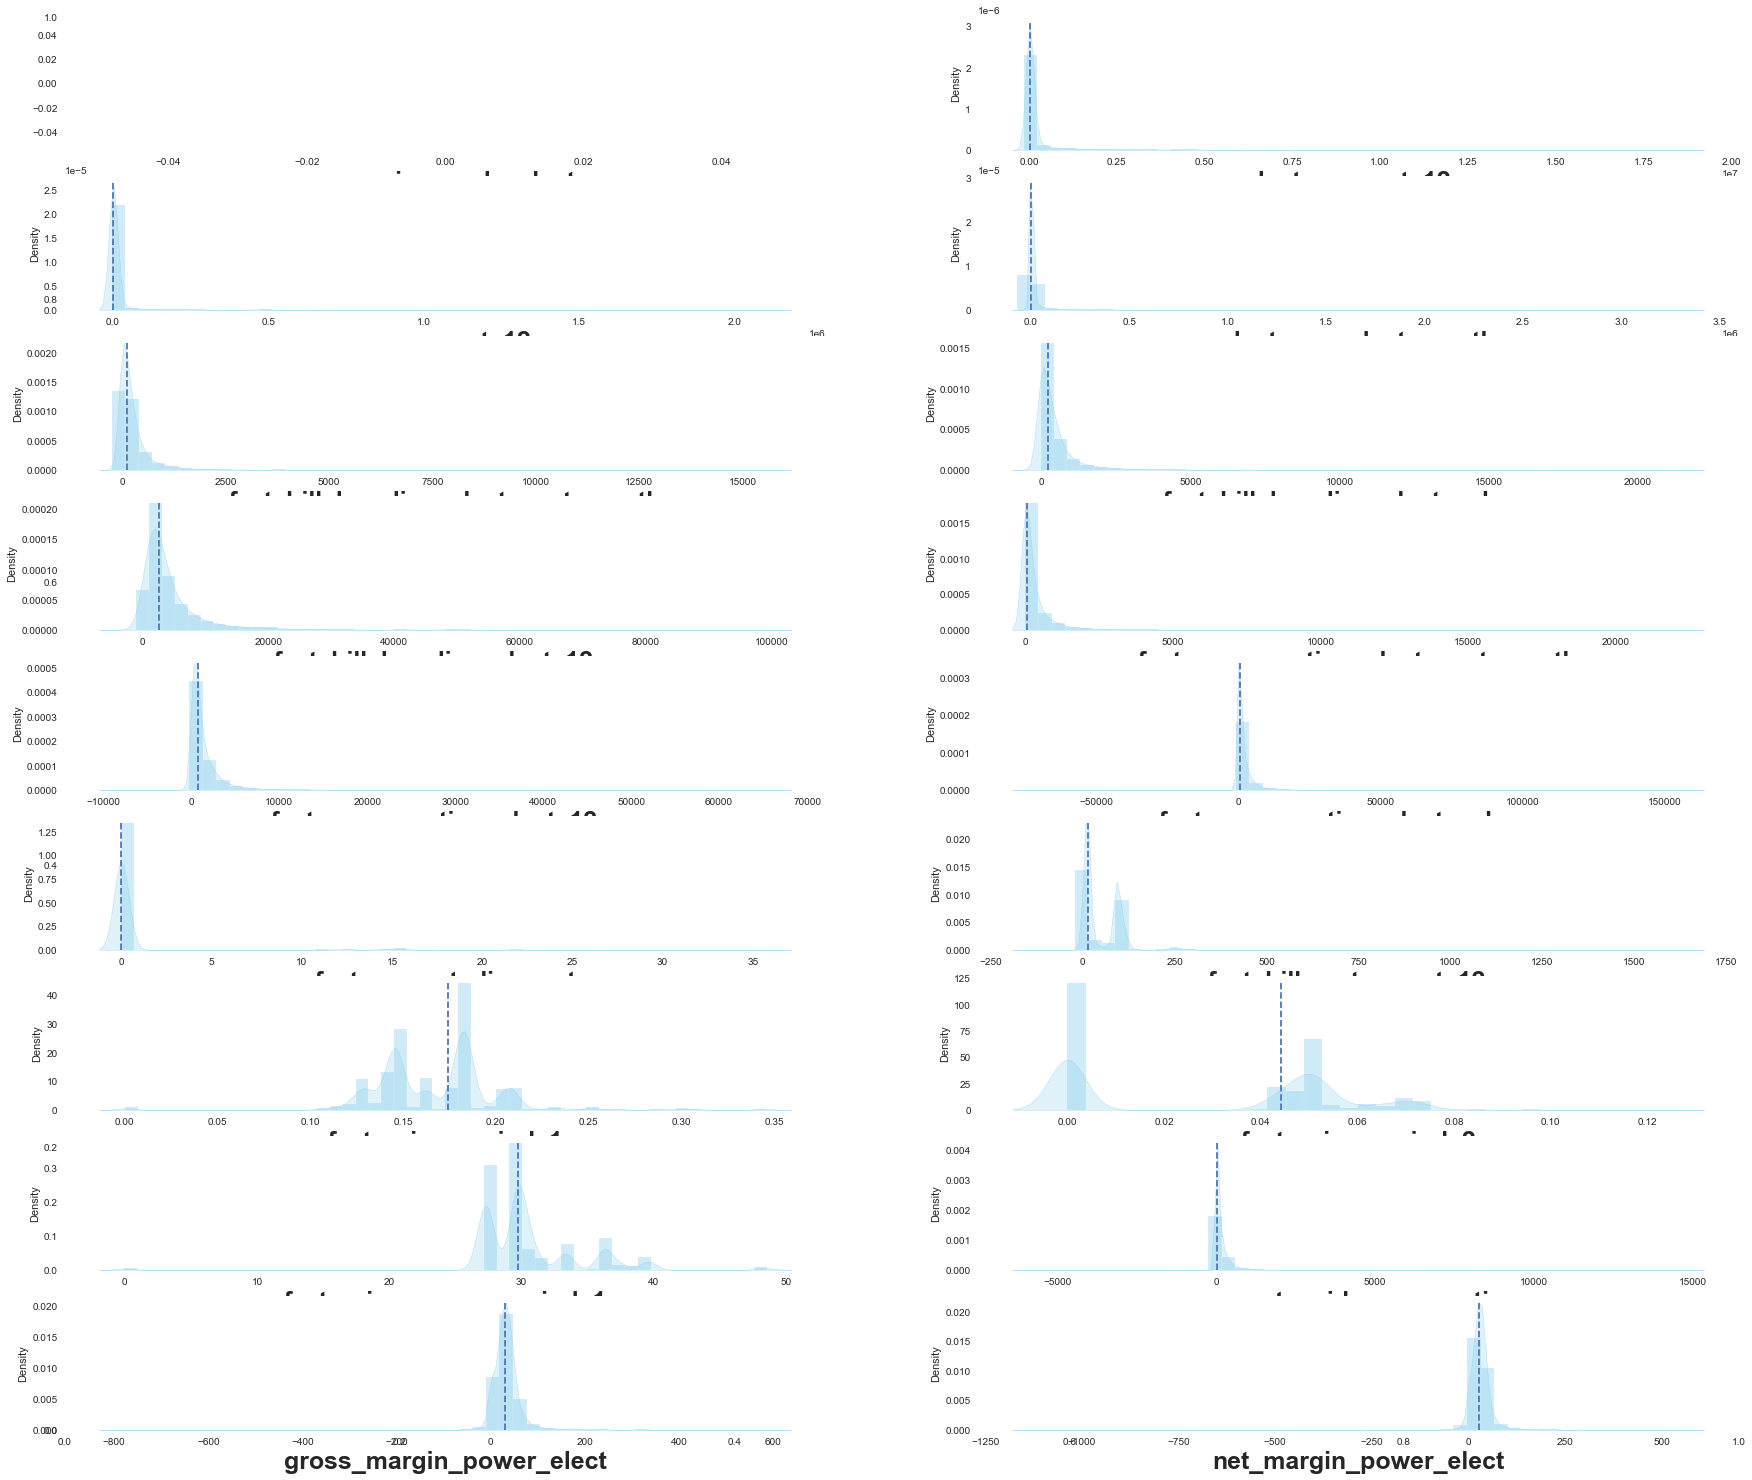

In [43]:
# Set initial plot options
sns.set_style('white')
fig, ax = plt.subplots(figsize = (30, 26))

# Loop over subplots
for i, col in enumerate(dataset.columns):
    ax = fig.add_subplot(9, 2, i+1)
    
    sns.distplot(dataset[col], 
                 color='skyblue',
                 kde_kws = {"shade":True},
                 kde=True,
                 ax=ax)
    
    # Add a vertical line
    plt.axvline(dataset[col].median(), ymax = 0.95, linestyle = "--")
    plt.xlabel(col, fontsize = 25, fontweight = "semibold")
    
# Despine visualizations
sns.despine(left=True)
fig.suptitle("Numerical variables", fontweight = "semibold", fontsize = 35)
    
plt.tight_layout()

plt.savefig('../images/numeric_vars.png')

### Categorical Variables

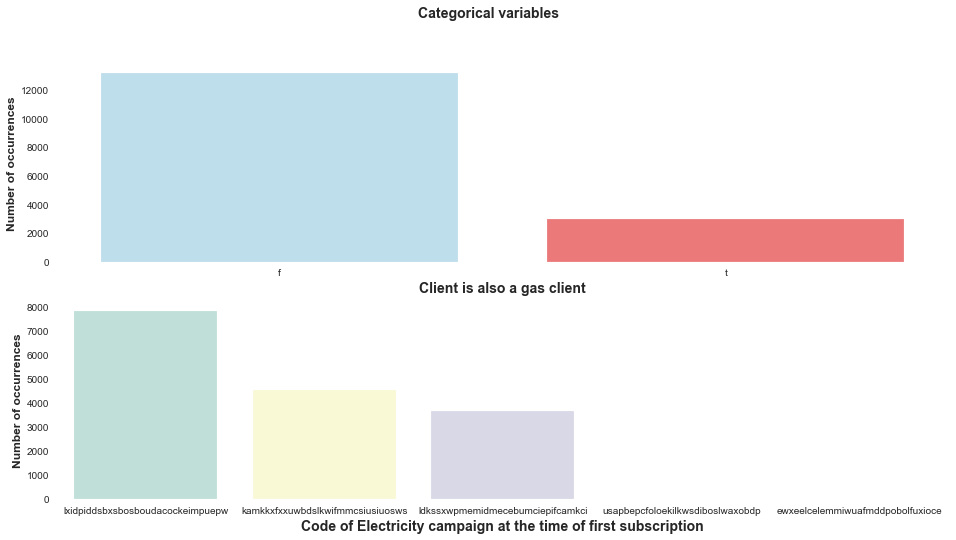

In [54]:
sns.set_style('white')
fig, axes = plt.subplots(2, 1, figsize = (16, 8))

# Create a count plot for variable 'client_got_gas'
sns.countplot(x = 'client_got_gas',
              data = train_dataset,
              palette = ['skyblue', 'r'],
              order = ['f', 't'],
              alpha = 0.6,
              ax = axes[0])

# Final styling touche
axes[0].set_ylabel("Number of occurrences", fontsize = 12, fontweight = "semibold")
axes[0].set_xlabel("Client is also a gas client", fontweight = "semibold", fontsize = 14)

# Create a count plot for variable 'client_got_gas'
sns.countplot(x = 'code_elect_campaign_first_subs',
              data = train_dataset,
              palette = 'Set3',
              alpha = 0.6,
              ax = axes[1])

# Final styling touche
# axes[1].tick_params(labelrotation = 70)
axes[1].set_ylabel("Number of occurrences", fontsize = 12, fontweight = "semibold")
axes[1].set_xlabel('Code of Electricity campaign at the time of first subscription', fontweight = "semibold", fontsize = 14)

# Despine visualizations
sns.despine(left=True)
fig.suptitle("Categorical variables", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/categorical_vars.png')
plt.show()

### Time Series Data

In [51]:
train_hist_data = pd.read_csv('aily_case_training_hist_data.csv', parse_dates=['reference_date'], 
                              index_col='contract_id')
test_hist_data = pd.read_csv('aily_case_training_hist_data.csv', parse_dates=['reference_date'], 
                              index_col='contract_id')

hist_data = pd.concat([train_hist_data, test_hist_data], axis = 0)

In [52]:
# Melt method for multiple linearplots
energy_melted = pd.melt(hist_data, id_vars='reference_date',
                 value_vars=['price_energy_1st_period', 'price_energy_2nd_period', 'price_energy_3rd_period'])

power_melted = pd.melt(hist_data, id_vars='reference_date',
                 value_vars=['price_power_1st_period', 'price_power_2nd_period', 'price_power_3rd_period'])

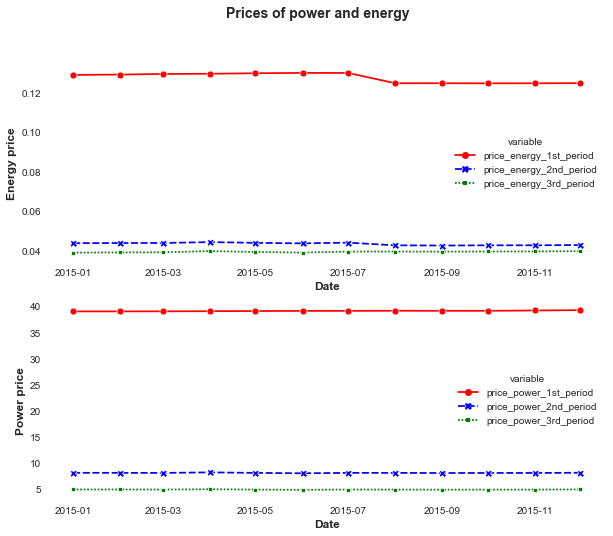

In [53]:
# Set initial plot options
sns.set_style('white')

# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Create a lineplot for time series of energy prices
sns.lineplot(x = 'reference_date', 
             y = "value", 
             # Set hue and linestyle by Attrition
             hue = "variable", 
             style = "variable", 
             data = energy_melted,
             # Change colors for each hue category
             palette = ['r', 'b', 'g'], 
             # Add points to lineplot and remove confidence interval
             markers = True, ci = None,
             ax = axes[0])

# Format subplot in axes
axes[0].set_ylabel("Energy price", fontsize = 12, fontweight = "semibold")
axes[0].set_xlabel("Date", fontsize = 12, fontweight = "semibold")


# Create a lineplot for time series of power prices
sns.lineplot(x = 'reference_date', 
             y = "value", 
             # Set hue and linestyle by Attrition
             hue = "variable", 
             style = "variable", 
             data = power_melted,
             # Change colors for each hue category
             palette = ['r', 'b', 'g'], 
             # Add points to lineplot and remove confidence interval
             markers = True, ci = None,
             ax = axes[1])

# Format subplot in axes
axes[1].set_ylabel("Power price", fontsize = 12, fontweight = "semibold")
axes[1].set_xlabel("Date", fontsize = 12, fontweight = "semibold")


# Despine plot
sns.despine()
plt.suptitle("Prices of power and energy", fontsize = 14, fontweight = "semibold")

plt.savefig('../images/time_series_vars.png')
plt.show()

<ul>
    <li>Consumption variables: they have low mean and follow positive skewed distributions and have fat tails in amont</li>
    <li>Price variables: 1st period is higher than 2nd and 3rd which may coincide with periods within a year</li>
    <li>Person specific variables: customers might be segmented according to: (i) antiquity in years (mean of 5 years), marketing campaigns</li>
</ul>

## Churned customers after a period of 3 months (March 2016)

In [10]:
round(train_output.groupby(['has_churned_over_next_3m']).size() / train_output.shape[0] * 100, 2)

has_churned_over_next_3m
0    90.09
1     9.91
dtype: float64

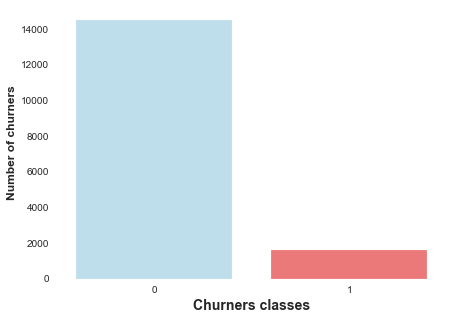

In [16]:
sns.set_style('white')
plt.figure(figsize=(7,5))

# Create a countplot
sns.countplot(x='has_churned_over_next_3m',
              data=train_output,
              order=[0, 1],
              # Set colour of hue and transperency
              palette = ["skyblue", 'r'],
              alpha = 0.6)

# Final styling touche
plt.ylabel("Number of churners", fontsize = 12, fontweight = "semibold")
plt.xlabel("Churners classes", fontweight = "semibold", fontsize = 14)

# Despine visualizations
sns.despine(left=True)
fig.suptitle("Distribution of Churners / non-Churners", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/churners.png')
plt.show()

## Churn Drivers (EDA)

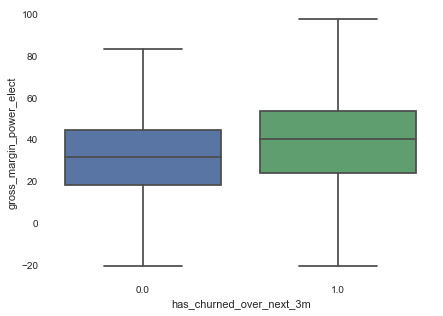

In [214]:
sns.set_style('white')
plt.figure(figsize=(7,5))

sns.boxplot(x = 'has_churned_over_next_3m',
            y = 'gross_margin_power_elect',
            data = dataset,
            sym = "",
            )

plt.savefig('../images/gross_margin.png')

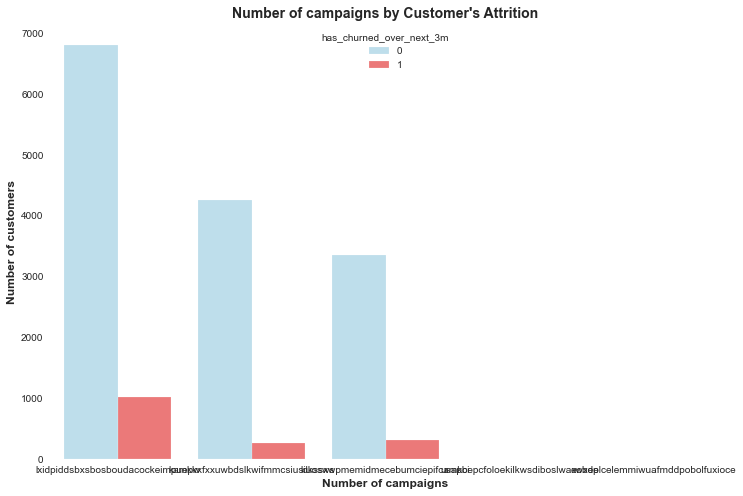

In [212]:
# Set initial plot options
sns.set_style('white')
plt.figure(figsize = (12, 8))

# Create a countplot
sns.countplot(x='code_elect_campaign_first_subs',
              # Group by Gender 
              hue = 'has_churned_over_next_3m', 
              data=train_dataset,
              # Set colour of hue and transperency
              palette = ['skyblue', 'r'],
              alpha = 0.6)

# Despine visualizations
sns.despine()
# Final styling touche
plt.ylabel("Number of customers", fontsize = 12, fontweight = "semibold")
plt.xlabel("Number of campaigns", fontsize = 12, fontweight = "semibold")
#plt.xticks(x, labels, rotation='vertical')
plt.title("Number of campaigns by Customer's Attrition", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/campaigns.png')
plt.show()

In [32]:
train_dataset.groupby('has_churned_over_next_3m')['contract_renewal_date'].mean()

has_churned_over_next_3m
0   2014-08-14 18:59:02.771244032
1   2015-07-18 18:20:32.351097344
Name: contract_renewal_date, dtype: datetime64[ns]

### Cluster

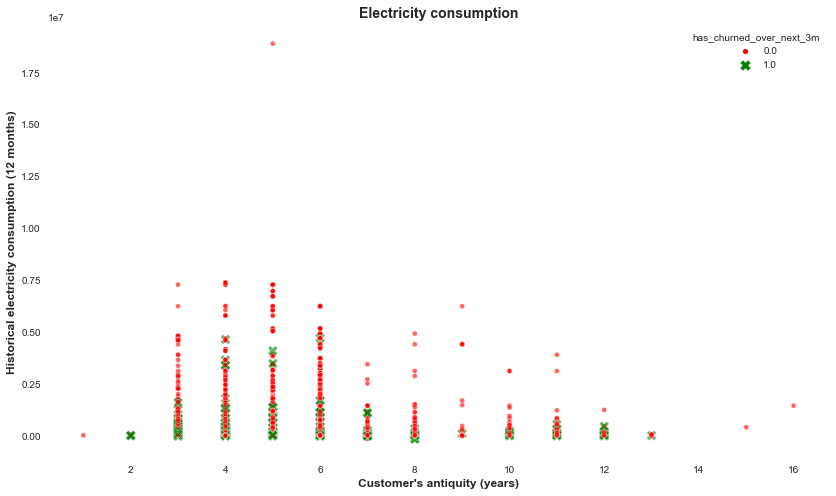

In [213]:
sns.set_style('white')
plt.figure(figsize = (14, 8))

# Create scatterplot
sns.scatterplot(x = "customer_antiquity_in_years", 
                y = "elect_cons_at_12m", 
                # Group by and change dot style and  by Attrition
                hue = "has_churned_over_next_3m",
                size = "has_churned_over_next_3m",  
                style = "has_churned_over_next_3m", 
                data = dataset, 
                # Change color of hue categories
                palette = ["r", "g"],
                alpha = 0.6)

# Despine plot
sns.despine()
# Final formatting touches
plt.xlabel("Customer's antiquity (years)", fontsize = 12, fontweight = "semibold")
plt.ylabel("Historical electricity consumption (12 months)", fontsize = 12, fontweight = "semibold")
plt.title("Electricity consumption", fontsize = 14, fontweight = "semibold")
plt.savefig('../images/elect_co.png')
plt.show()

In [222]:
# Create categories for raises
dataset['total_net_margin_cat'] = pd.cut(dataset['total_net_margin'],
                                          # Define cutoff points 10-15, 15-20, 20-25 
                                          [-2072, 1490, 5050, 8609, 12174], 
                                          # Define category labels
                                          labels = ['0-25%', '25-50%', '50-75%', '75%-100%']) 

In [231]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, d07d473503c6bef7cf1922fab1f88f3e to 44e27783ba74e3c10aba49fae358fe0b
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   company_category                     8221 non-null   object        
 1   campaing_code_elect                  0 non-null      float64       
 2   channel                              14846 non-null  object        
 3   elect_cons_at_12m                    20120 non-null  int64         
 4   gas_cons_at_12m                      20120 non-null  int64         
 5   elect_cons_last_month                20120 non-null  int64         
 6   contract_activation_date             20120 non-null  datetime64[ns]
 7   contract_end_date                    20118 non-null  datetime64[ns]
 8   contract_fist_act_date               4385 non-null   datetime64[ns]
 9   contract_last_mod_date        

Simple descriptive statistics show that SME churners pay a higher energy/power price despite of having higher subscribed power. Perhaps this is the reason for a less electricity/gas consumption than peers (both on a historical and forecasted basis). They are less loyal (number of active products), though renewal contract date is more recent than for non-churners'. It also seems that first marketing campaign also influences permanence.

# Churn modeling
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Feature preprocessing
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### Previous steps

In [207]:
features = dataset.drop('has_churned_over_next_3m', axis = 1)

Before performing the bulk of data preprocessing, let's conduct the following steps:<br>
<ol>
     <li>drop columns with high number of nan values</li>
    <li>create new variable: contract duration</li>
     <li>check for pair variable correlation and drop the highly correlated ones to avoid multicollineality</li>
</ol>

In [208]:
features = features[features.columns[features.isna().sum() < 200]]

In [209]:
features['contract_duration'] = (features['contract_activation_date'] - features['contract_end_date'])/np.timedelta64(1, 'M')

In [210]:
dates_to_drop = features.columns[features.columns.isin(dates)]
features = features.drop(dates_to_drop, axis = 1)

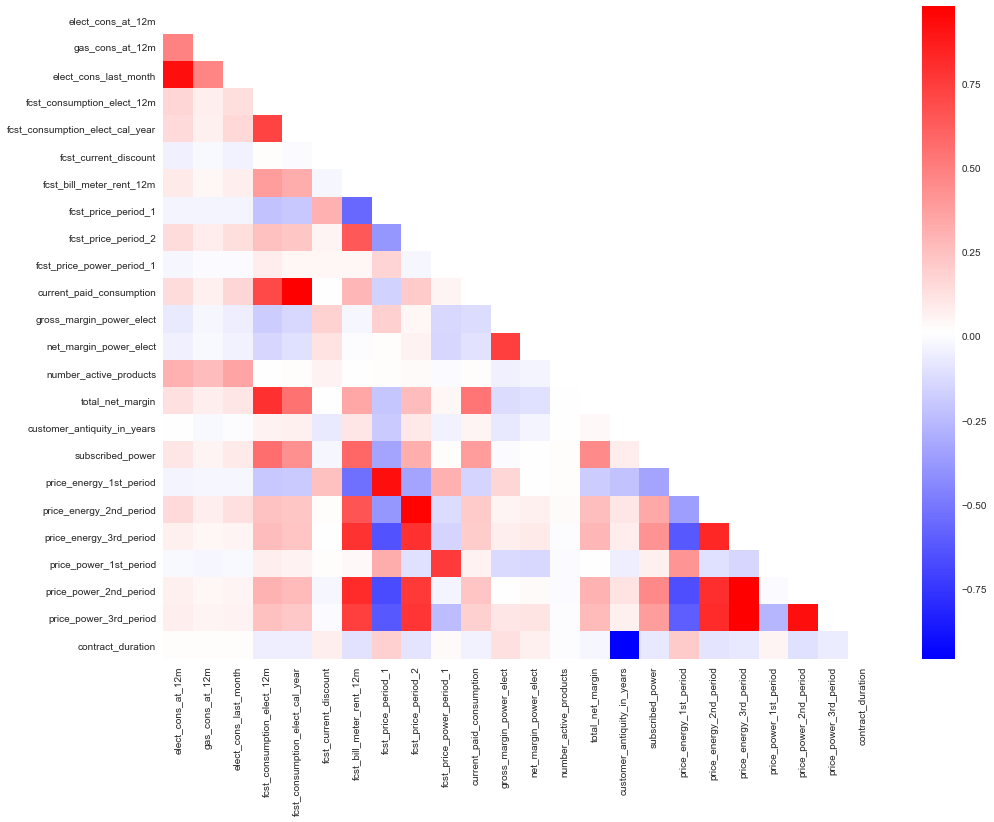

In [211]:
sns.set_style('white')
plt.figure(figsize = (16,12))

mask = np.zeros_like(features.corr(), dtype = np.bool)

mask[np.triu_indices_from(mask)] = True

sns.heatmap(features.corr(), mask = mask, cmap = 'bwr')

plt.savefig('../images/corr.png')
plt.show()

In [14]:
features.corr()

elect_cons_at_12m  gas_cons_at_12m  \
elect_cons_at_12m                         1.000000         0.485839   
gas_cons_at_12m                           0.485839         1.000000   
elect_cons_last_month                     0.926037         0.476036   
fcst_consumption_elect_12m                0.167258         0.074424   
fcst_consumption_elect_cal_year           0.148203         0.067307   
fcst_current_discount                    -0.043970        -0.019153   
fcst_bill_meter_rent_12m                  0.086577         0.047114   
fcst_price_period_1                      -0.033123        -0.030216   
fcst_price_period_2                       0.146611         0.080915   
fcst_price_power_period_1                -0.025942        -0.006249   
current_paid_consumption                  0.145964         0.069353   
gross_margin_power_elect                 -0.065781        -0.024718   
net_margin_power_elect                   -0.044945        -0.015796   
number_active_products                    0.307047         0.266227   
total_net_margin                          0.129416         0.072379   
customer_antiquity_in_years               0.004847        -0.014641   
subscribed_power                          0.108078         0.052987   
price_energy_1st_period                  -0.027919        -0.020785   
price_energy_2nd_period                   0.148015         0.075773   
price_energy_3rd_period                   0.064704         0.046254   
price_power_1st_period                   -0.014152        -0.020704   
price_power_2nd_period                    0.068351         0.042533   
price_power_3rd_period                    0.074697         0.053487   

                                 elect_cons_last_month  \
elect_cons_at_12m                             0.926037   
gas_cons_at_12m                               0.476036   
elect_cons_last_month                         1.000000   
fcst_consumption_elect_12m                    0.135457   
fcst_consumption_elect_cal_year               0.161057   
fcst_current_discount                        -0.038684   
fcst_bill_meter_rent_12m                      0.077815   
fcst_price_period_1                          -0.029753   
fcst_price_period_2                           0.132652   
fcst_price_power_period_1                    -0.007870   
current_paid_consumption                      0.162469   
gross_margin_power_elect                     -0.057134   
net_margin_power_elect                       -0.038979   
number_active_products                        0.354880   
total_net_margin                              0.107793   
customer_antiquity_in_years                   0.001313   
subscribed_power                              0.092157   
price_energy_1st_period                      -0.019769   
price_energy_2nd_period                       0.128441   
price_energy_3rd_period                       0.053235   
price_power_1st_period                       -0.012027   
price_power_2nd_period                        0.055692   
price_power_3rd_period                        0.061138   

                                 fcst_consumption_elect_12m  \
elect_cons_at_12m                                  0.167258   
gas_cons_at_12m                                    0.074424   
elect_cons_last_month                              0.135457   
fcst_consumption_elect_12m                         1.000000   
fcst_consumption_elect_cal_year                    0.729380   
fcst_current_discount                              0.020021   
fcst_bill_meter_rent_12m                           0.383396   
fcst_price_period_1                               -0.222763   
fcst_price_period_2                                0.252183   
fcst_price_power_period_1                          0.082178   
current_paid_consumption                           0.705117   
gross_margin_power_elect                          -0.184796   
net_margin_power_elect                            -0.146731   
number_active_products                             0.

Pairs of variables with higher correlation rates:
<ul>
    <li><i>fcst_consumption_elect_cal_year</i> and <i>current_paid_consumption</i>: 0.98</li>
    <li><i>fcst_price_period_2</i> and <i>price_energy_2nd_period</i>: 0.99</li>
    <li><i>price_power_2nd_period</i> and <i>price_energy_3rd_period</i>: 0.97</li>
    <li><i>price_power_3rd_period</i> and <i>price_energy_3rd_period</i>: 0.98</li>
</ul><br>
We shall then drop <i>price_energy_3rd_period</i>, <i>fcst_price_period_2</i> (as we keep historical 2nd period energy prices, after removing 3rd period) and <i>fcst_consumption_elect_cal_year</i> (since we already have a forecast consumption on 12 months).

In [84]:
features = features.drop(['price_energy_3rd_period', 'fcst_price_period_2', 'fcst_consumption_elect_cal_year'], axis=1)

In [62]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, d07d473503c6bef7cf1922fab1f88f3e to 44e27783ba74e3c10aba49fae358fe0b
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   elect_cons_at_12m               20120 non-null  int64  
 1   gas_cons_at_12m                 20120 non-null  int64  
 2   elect_cons_last_month           20120 non-null  int64  
 3   fcst_consumption_elect_12m      20120 non-null  float64
 4   fcst_current_discount           19970 non-null  float64
 5   fcst_bill_meter_rent_12m        20120 non-null  float64
 6   fcst_price_period_1             19970 non-null  float64
 7   fcst_price_power_period_1       19970 non-null  float64
 8   client_got_gas                  20120 non-null  object 
 9   current_paid_consumption        20120 non-null  float64
 10  gross_margin_power_elect        20105 non-null  float64
 11  net_margin_power_elect          20105 no

### Preprocessing

In [86]:
def preproc(data):
    
    # Numerical features: 
    """let's first adopt an imputation method for missing values based on the distribution's median
    and second standardise</b> data to avoid degradation of the predictive performance of many machine
    learning algorithms."""

    num_data = data.select_dtypes(include=['float64', 'int64']).copy()
    
    # Median imputation
    median_imputer = SimpleImputer(strategy='median')
    num_data.iloc[:,:] = median_imputer.fit_transform(num_data)
    
    # Data scaling
    scaler = RobustScaler()
    num_data.iloc[:, :] = scaler.fit_transform(num_data)
    
    
    
    # Categorical features:
    """let's first impute NAs consisting on the following steps: (i) ordinal encoding as imputation does not work on 
    NA values, (ii) effectively impute NAs with KNN method, (iii) operate an inverse transform function in order
    to 'categorise' back the variables. Second, one hot encoding of the campaign variable. And finally,
    concatenate the categorical dataframe in a single one."""
    
    cat_data = data[['code_elect_campaign_first_subs']].copy()
    
    # Second, impute NAs
    # Ordinal Encoding of cat_data_train DataFrame
    ordinal_enc_dict = {}

    for col_name in cat_data:
        # Create an Ordinal Encoder for col
        ordinal_enc_dict[col_name] = OrdinalEncoder()
        col = cat_data[col_name]
    
        # Select non-null values of columns (Ordinal Encoder does not work with NAs)
        col_not_null = col[col.notnull()]
        reshaped_vals = col_not_null.values.reshape(-1, 1)
        encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    
        # Store the values to non-null values of the column in data
        cat_data.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)
        
    # Create KNN imputer
    KNN_imputer = KNN()

    # Impute and round the users DataFrame
    cat_data.iloc[:, :] = np.round(KNN_imputer.fit_transform(cat_data))
    
    # Loop over the columns
    for col_name in cat_data:
    
        # Reshape the data
        reshaped = cat_data[col_name].values.reshape(-1, 1)
    
        # Perform inverse transform of the ordinally encoded columns
        cat_data[col_name] = ordinal_enc_dict[col_name].inverse_transform(reshaped)
    
    
    # Third, label binary categorical variable
    got_gas = data['client_got_gas'].copy()
    label_enc = LabelEncoder()
    cat_data['client_got_gas'] = label_enc.fit_transform(got_gas)
    # cat_data['client_got_gas'] = cat_data['client_got_gas'].replace({'f': 0, 't': 1})
    
    # Fourth, get dummies and keep those with lower number of NaNs
    dummies = pd.get_dummies(cat_data['code_elect_campaign_first_subs'])
    
    # Fifth, concatenate dataframes
    cat_data = pd.concat([cat_data, dummies], axis = 1)
    cat_data = cat_data.drop(['code_elect_campaign_first_subs'], axis = 1)
    
    
    
    # Concatenate two dataframes into a single one
    preproc_df = [num_data, cat_data]
    all_data = pd.DataFrame(reduce(lambda x, y: x.join(y, on = x.index, how = 'left'), preproc_df))
    
    
    return all_data 
    

In [87]:
features = preproc(features)
print(features.isnull().values.sum())

Imputing row 1/20120 with 0 missing, elapsed time: 18.683
Imputing row 101/20120 with 0 missing, elapsed time: 18.684
Imputing row 201/20120 with 0 missing, elapsed time: 18.684
Imputing row 301/20120 with 0 missing, elapsed time: 18.684
Imputing row 401/20120 with 0 missing, elapsed time: 18.684
Imputing row 501/20120 with 0 missing, elapsed time: 18.684
Imputing row 601/20120 with 0 missing, elapsed time: 18.685
Imputing row 701/20120 with 0 missing, elapsed time: 18.685
Imputing row 801/20120 with 0 missing, elapsed time: 18.685
Imputing row 901/20120 with 0 missing, elapsed time: 18.685
Imputing row 1001/20120 with 0 missing, elapsed time: 18.685
Imputing row 1101/20120 with 0 missing, elapsed time: 18.685
Imputing row 1201/20120 with 0 missing, elapsed time: 18.686
Imputing row 1301/20120 with 0 missing, elapsed time: 18.686
Imputing row 1401/20120 with 0 missing, elapsed time: 18.686
Imputing row 1501/20120 with 0 missing, elapsed time: 18.686
Imputing row 1601/20120 with 0 missi

In [88]:
features.describe()

elect_cons_at_12m  gas_cons_at_12m  elect_cons_last_month  \
count       20120.000000     2.012000e+04           20120.000000   
mean            4.049382     1.764942e+04               4.534686   
std            15.245714     9.971148e+04              19.623870   
min            -3.213441    -3.056000e+03             -21.782263   
25%            -0.213587     0.000000e+00              -0.220102   
50%             0.000000     0.000000e+00               0.000000   
75%             0.786413     0.000000e+00               0.779898   
max           368.202572     2.141273e+06            1070.689160   

       fcst_consumption_elect_12m  fcst_current_discount  \
count                2.012000e+04           20120.000000   
mean                 5.525149e-01               0.558554   
std                  1.876206e+00               2.942381   
min                 -7.706509e+00               0.000000   
25%                 -3.011811e-01               0.000000   
50%                 -4.318343e-17               0.000000   
75%                  6.988189e-01               0.000000   
max                  5.048667e+01              35.893917   

       fcst_bill_meter_rent_12m  fcst_price_period_1  \
count              20120.000000         20120.000000   
mean                   0.454827            -0.173347   
std                    0.705909             0.860956   
min                   -2.279871            -4.529178   
25%                   -0.034568            -0.757556   
50%                    0.000000             0.000000   
75%                    0.965432             0.242444   
max                   20.706102             4.442332   

       fcst_price_power_period_1  current_paid_consumption  \
count               20120.000000              2.012000e+04   
mean                    0.201611              6.931814e-01   
std                     1.162301              2.278131e+00   
min                    -7.797171             -3.970887e+01   
25%                    -0.650094             -2.023145e-01   
50%                     0.000000             -2.241927e-17   
75%                     0.349906              7.976855e-01   
max                     4.918021              9.573874e+01   

       gross_margin_power_elect  net_margin_power_elect  \
count              20120.000000            20120.000000   
mean                   0.116927                0.039473   
std                    1.402991                1.669155   
min                  -33.257492              -50.894375   
25%                   -0.502951               -0.517377   
50%                    0.000000                0.000000   
75%                    0.497049                0.482623   
max                   23.277151               24.125874   

       number_active_products  total_net_margin  customer_antiquity_in_years  \
count             20120.00000      20120.000000                 20120.000000   
mean                  0.34826          0.445123                     0.011829   
std                   1.45777          1.595208                     0.839074   
min                   0.00000        -17.899208                    -2.000000   
25%                   0.00000         -0.303825                    -0.500000   
50%                   0.00000          0.000000                     0.000000   
75%                   0.00000          0.696175                     0.500000   
max                  31.00000        101.479475                     5.500000   

       subscribed_power  price_energy_1st_period  price_energy_2nd_period  \
count      20120.000000             20120.000000             20120.000000   
mean           0.785496                -0.236005                -0.308204   
std            2.673879                 0.919424                 0.486556   
min           -1.731453                -5.582871                -0.838749   
25%           -0.257235                -0.882525                -0.838749   
50%            0.000000                 0.000000                 0.000000 

### Train / Test Split

In [89]:
preproc_dataset = features.join(train_output, on = features.index, how = 'left').sort_values(by = 'has_churned_over_next_3m')

In [90]:
X_train, X_test, y_train, y_test = train_test_split(preproc_dataset.drop('has_churned_over_next_3m', axis = 1),
                                                    preproc_dataset['has_churned_over_next_3m'],
                                                    test_size=0.2, random_state = 42, shuffle = False)

In [91]:
y_test.isnull().values.sum()

4024

## Churn prediction
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### Logistic Regression

In [92]:
# Initialise the model
clf_lr = LogisticRegression()

# Fit the model
lr = clf_lr.fit(X_train, y_train)

# Predict
lr_y_train_pred = lr.predict(X_train)
lr_y_test_pred = lr.predict(X_test)

lr_y_train_predprob = lr.predict_proba(X_train)

#### Model performance metrics<br>
<ul>
    <li>Accuracy - The % of correctly predicted labels (both Churn and non Churn). However, for imbalanced classes, accuracy may not a good metric:</li>
    <li>Precision - The % of total model's positive class predictions (here-predicted as Churn) that were correctly classied</li>
    <li>Recall - The % of total positive class samples (all churned customers) that were correctly classified</li>
    
</ul>

In [94]:
# Accuracy
lr_accuracy = round(np.mean(cross_val_score(clf_lr, X_train, y_train, scoring="accuracy")), 4)
lr_auc = round(np.mean(cross_val_score(clf_lr, X_train, y_train, scoring="roc_auc")), 4)

print('accuracy score: {},\narea under the curve: {}'.format(lr_accuracy, lr_auc))

# Precision and Recall matrix
lr_precision = precision_score(y_train, lr_y_train_pred)
lr_recall = recall_score(y_train, lr_y_train_pred)
print('training precision: {} and training recall: {}'.format(round(lr_precision, 4), round(lr_recall, 4)))



/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

accuracy score: 0.8991,
area under the curve: 0.5717
training precision: 0.2075 and training recall: 0.0069


/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Brier Score
lr_bs = brier_score_loss((y_train, lr_y_train_predprob[:, 1])
print('brier score: {}'.format(round(lr_bs, 4)))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train, lr_y_train_pred)

# ROC curve plot
sns.set_style('white')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

In [98]:
# Regularisation and feature selection
# Initialise the model
clf_l1 = LogisticRegression(penalty = 'l1', C = 0.025, solver = 'liblinear')

# Fit the model
l1 = clf_lr.fit(X_train, y_train)

# Predict
l1_y_train_pred = lr.predict(X_train)
l1_y_test_pred = lr.predict(X_test)

l1_y_train_predprob = lr.predict_proba(X_train)

In [97]:
# Tuning L1 parameters

C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C), 5))

l1_metrics[:,0] = C

for index in range(0, len(C)):
    lr = LogisticRegression(penalty = 'l1', C = C[index], solver = 'liblinear')
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    
    l1_metrics[index,1] = np.count_nonzero(lr.coef_)
    l1_metrics[index,2] = accuracy_score(y_train, y_train_pred)
    l1_metrics[index,3] = precision_score(y_train, y_train_pred)
    l1_metrics[index,4] = recall_score(y_train, y_train_pred)
    
col_names = ['C','Non-Zero Coeffs','Accuracy','Precision','Recall']

print(pd.DataFrame(l1_metrics, columns=col_names))

        C  Non-Zero Coeffs  Accuracy  Precision    Recall
0  1.0000             26.0  0.900659   0.300000  0.001881
1  0.5000             26.0  0.900534   0.250000  0.001881
2  0.2500             23.0  0.900783   0.375000  0.001881
3  0.1000             23.0  0.900783   0.375000  0.001881
4  0.0500             19.0  0.900783   0.333333  0.001254
5  0.0250             17.0  0.900845   0.400000  0.001254
6  0.0100             10.0  0.900783   0.250000  0.000627
7  0.0050              9.0  0.900907   0.000000  0.000000
8  0.0025              5.0  0.900907   0.000000  0.000000


/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
# Accuracy
l1_accuracy = round(np.mean(cross_val_score(clf_l1, X_train, y_train, scoring="accuracy")), 4)
l1_auc = round(np.mean(cross_val_score(clf_l1, X_train, y_train, scoring="roc_auc")), 4)

print('accuracy score: {},\narea under the curve: {}'.format(l1_accuracy, l1_auc))

# Precision and Recall matrix
l1_precision = precision_score(y_train, l1_y_train_pred)
l1_recall = recall_score(y_train, l1_y_train_pred)
print('training precision: {} and training recall: {}'.format(round(l1_precision, 4), round(l1_recall, 4)))

# Brier Score
l1_bs = brier_score_loss((y_train, l1_y_train_predprob[:, 1]))
print('brier score: {}'.format(round(lr_bs, 4)))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train, l1_y_train_pred)

# ROC curve plot
sns.set_style('white')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()


accuracy score: 0.9008,
area under the curve: 0.6403
training precision: 0.0 and training recall: 0.0


/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [162]:
coefficients = pd.concat([pd.DataFrame(features.columns), pd.DataFrame(np.transpose(lr.coef_))], axis = 1)

coefficients.columns = ['Feature', 'Coefficient']

coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])

coefficients = coefficients[coefficients['Coefficient']!=0]

print(coefficients.sort_values(by=['Coefficient']))

                     Feature  Coefficient  Exp_Coefficient
0          elect_cons_at_12m    -0.012154         0.987920
2      elect_cons_last_month    -0.007413         0.992614
1            gas_cons_at_12m    -0.000003         0.999997
10    net_margin_power_elect     0.001411         1.001412
9   gross_margin_power_elect     0.014627         1.014734


### Decision Trees

In [100]:
clf_dt = DecisionTreeClassifier()

# Fit the model
clf_dt = clf_dt.fit(X_train, y_train)

# Predict
clf_dt_y_train_pred = clf_dt.predict(X_train)
clf_dt_y_test_pred = clf_dt.predict(X_test)

clf_dt_y_train_predprob = clf_dt.predict_proba(X_train)

In [101]:
# Accuracy and Area under the curve
clf_dt_accuracy = round(np.mean(cross_val_score(clf_dt, X_train, y_train, scoring="accuracy")), 4)
clf_dt_auc = round(np.mean(cross_val_score(clf_dt, X_train, y_train, scoring="roc_auc")), 4)
print('accuracy score: {},\narea under the curve: {}'.format(clf_dt_accuracy, clf_dt_auc))

accuracy score: 0.8305,
area under the curve: 0.5664


In [161]:
exported = tree.export_graphviz(decision_tree = clf_dt, out_file = None, feature_names = features.columns,
                                precision = 1, class_names = ['Not churn','Churn'],filled = True)

graph = graphviz.Source(exported, format = 'png')

display(graph)
# display_image("/home/isabel/Repos/AilyLabs/images/decision_tree_rules.png")

### Random Forest

In [115]:
# Model fitting
clf_rf = RandomForestClassifier()
rf = clf_rf.fit(X_train, y_train)

# Predict
clf_rf_y_train_pred = clf_rf.predict(X_train)
clf_rf_y_test_pred = clf_rf.predict(X_test)

clf_rf_y_test_predprob = clf_rf.predict_proba(X_test)

In [108]:
# Train scores
clf_rf_accuracy = round(np.mean(cross_val_score(clf_rf, X_train, y_train, scoring='accuracy')), 4)
clf_rf_auc = round(np.mean(cross_val_score(clf_rf, X_train, y_train, scoring='roc_auc')), 4)
print('accuracy score: {},\narea under the curve: {}'.format(clf_rf_accuracy, clf_rf_auc))            

accuracy score: 0.9054,
area under the curve: 0.6877


In [130]:
# Hyperparameter tuning with RandomizedSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rscv_rf = RandomizedSearchCV(clf_rf,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid,
                          scoring='accuracy',
                          random_state=1)

In [131]:
# Fit the model
rscv_rf = rscv_rf.fit(X_train, y_train)

In [133]:
# Train prediction
rscv_rf_y_train_pred = rscv_rf.predict(X_train)
rscv_rf_y_test_pred = rscv_rf.predict(X_test)

rscv_rf_y_train_predprob = rscv_rf.predict_proba(X_train)

# Test prediction
rscv_rf_pred_rscv = rscv_rf.predict(X_test)
rscv_rf_predprob_rscv = rscv_rf.predict_proba(X_test)

In [132]:
print('best score: {}, best parameters: {}'.format(rscv_rf.best_score_, rscv_rf.best_params_))

best score: 0.9028330236426187, best parameters: {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': 110, 'bootstrap': True}


In [134]:
# Train scores
clf_rscv_accuracy = round(np.mean(cross_val_score(rscv_rf, X_train, y_train, scoring='accuracy')), 4)
clf_rscv_auc = round(np.mean(cross_val_score(rscv_rf, X_train, y_train, scoring='roc_auc')), 4)
print('accuracy score: {},\narea under the curve: {}'.format(clf_rf_accuracy, clf_rf_auc)) 

# Precision and Recall matrix
clf_rscv_precision = precision_score(y_train, rscv_rf_y_train_pred)
clf_rscv_recall = recall_score(y_train, rscv_rf_y_train_pred)
print('training precision: {} and training recall: {}'.format(round(rscv_rf_precision, 4), round(rscv_rf_recall, 4)))

# Brier Score
rscv_rf_bs = brier_score_loss((y_train, rscv_rf_y_train_predprob[:, 1]))
print('brier score: {}'.format(round(rscv_rf_bs, 4)))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train, rscv_rf_y_train_pred)

# ROC curve plot
sns.set_style('white')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

accuracy score: 0.9054,
area under the curve: 0.6877


NameError: name 'rscv_rf_precision' is not defined

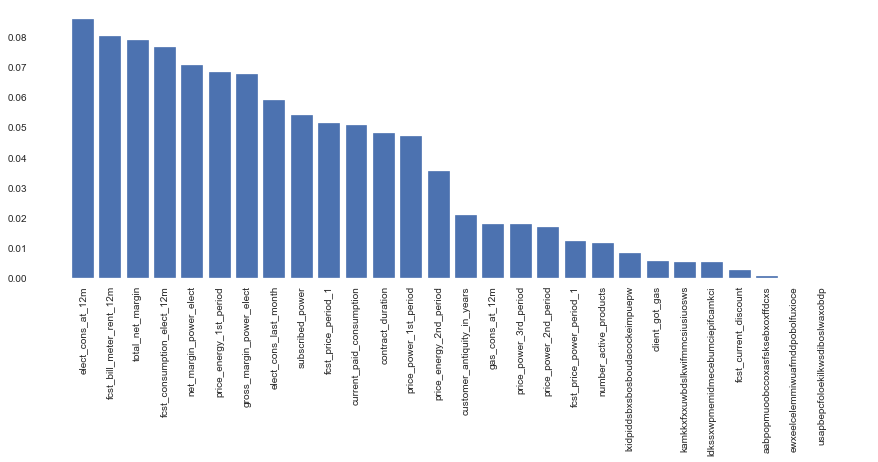

In [104]:
# Feature importances

sns.set_style('white')
plt.rcParams["figure.figsize"] = (15, 5)

# Get feature importances from our gradient boosting model
importances = clf_rf.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(X_train.columns)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

### Support Vector Machines

In [106]:
# Initialise the model
clf_svc = SVC(probability = True)

# Fit the model
svc = clf_svc.fit(X_train, y_train)

# Predict
svc_y_train_predprob = svc.predict_proba(X_train)
svc_y_train_pred = svc.predict(X_test)

In [109]:
svc_accuracy = round(np.mean(cross_val_score(clf_svc, X_train, y_train, cv=5, scoring='accuracy'), 4))
svc_auc = round(np.mean(cross_val_score(clf_svc, X_train, y_train, cv=5, scoring='roc_auc'), 4))

print('accuracy score: {},\n area under the curve: {}'.format(svc_accuracy, svc_auc))

AxisError: axis 4 is out of bounds for array of dimension 1

## Results

In [111]:
clf_rf_y_train_predprob

array([[1.  , 0.  ],
       [0.98, 0.02],
       [1.  , 0.  ],
       ...,
       [0.41, 0.59],
       [0.35, 0.65],
       [0.3 , 0.7 ]])

In [122]:
output = pd.read_csv('aily_case_test_output_template.csv', index_col = 'contract_id')
output['does_churn'] = clf_rf_y_test_pred
output['prob_of_churn'] = clf_rf_y_test_predprob[:, 1]
output = output.sort_values(by='prob_of_churn', ascending=False)
output.to_csv('../reports/output.csv')


In [124]:
results = pd.read_csv('../reports/output.csv', index_col = 'contract_id')

In [125]:
results.describe()

does_churn  prob_of_churn
count  4024.000000    4024.000000
mean      0.010437       0.190589
std       0.101642       0.100570
min       0.000000       0.010000
25%       0.000000       0.120000
50%       0.000000       0.170000
75%       0.000000       0.240000
max       1.000000       0.690000

In [126]:
print(results[results['does_churn'] == 1].count())

does_churn       42
prob_of_churn    42
dtype: int64


# Marketing campaign: 20% discount churned custormers
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

We shall undergo the following steps
<ol>
    <li>compute the discount by multiplying columns <i>fcst_consumption_elect_12m</i> and <i>fcst_meter_rent_elect_12m</i>, and deduct 20% bill for churned customers</li>
    <li>deduct the discount for churned customers in the variable <i>total_net_margin</i></li>
    <li>retrain the random forest model to output new predictions in terms of churn and associated predicted probabilities in order to assess campaign's effectiveness</li>
</ol>

In [46]:
dsc_dataset = preproc_dataset.copy()

# create new column by multiplying bill of meter rental for the next 12m and consumption forecast over the next 12m
dsc_dataset['fcst_billed_consumption_12m'] = preproc_dataset['fcst_consumption_elect_12m'].mul(preproc_dataset['fcst_bill_meter_rent_12m'])

# drop variables in excess. We decide to keep the variable 'fcs_current_discount', since nothing is being said about current discounts
dsc_dataset = dsc_dataset.drop(['fcst_consumption_elect_12m', 'fcst_bill_meter_rent_12m'], axis = 1)

# mask for churned customers
mask = results[results['does_churn'] == 1].index

# deduct discount from total margin values for churned customers
#for index, row in dsc_dataset.loc[mask, :].iterrows():
 #   dsc_dataset.loc[index, dsc_dataset['total_net_margin']] = dsc_dataset['total_net_margin'] - dsc_dataset['fcst_billed_consumption_12m'].mul(0.2)

# calculate discount for churned customers
#dsc_dataset.loc[mask, dsc_dataset['fcst_billed_consumption_12m']] = dsc_dataset['fcst_billed_consumption_12m'].mul(0.8)


